# Shinkansen Travel Experience - Academic Hackathon
## Solution by Oscar Suarez Lechado - o@oszl.xyz
### 12th Nov. 2022 - MIT IDSS Data Science and Machine Learning: Making Data-Driven Decisions Program

**---------------------------------------------------------------------------------------------------------------------------**

__OBJECTIVE:  Predict whether a passenger was satisfied or not considering his/her overall experience of traveling on the Shinkansen Bullet Train__

This problem aims to determine the relative importance of each parameter of the provided data with regards to their contribution to the passenger's overall travel experience. 

The on-time performance of the trains along with passenger information is published in a file. These passengers were later asked to provide their feedback on various parameters related to the travel along with their overall experience. These collected details are made available in the survey report.

In the survey, each passenger was explicitly asked whether they were satisfied with their overall travel experience or not, and that is captured in the data of the survey report under the variable labeled ‘Overall_Experience’. 

The objective of this problem is to understand which parameters play an important role in swaying passenger feedback towards a positive scale.

**---------------------------------------------------------------------------------------------------------------------------**

## TABLE OF CONTENTS:
* [Main idea](#Idea)
* [Library imports](#Libs)
* [Helper Functions](#Funcs)
* [Loading data and transformations](#Data)
* [Baseline XGB model](#Baseline)
* [XGB Tuning](#Tuning)
* [CSV Submission](#Submission)
* [Further work and undeveloped ideas](#Future)
* [Final notes](#Notes)

## 1. Main Idea <a class="anchor" id="Idea"></a>  

Based on exploratory analysis of the data, exploratory model testing, and previous experience; an XGBoost model was selected to solve this challenge. On that exploratory phase, the logic behind feature engineering/transformation was addressed. Also, other models were used to validate the relative importance of the features. 

This notebook will reflect these transformations and analysis-based decisions. However, the focus will be to show the training and hyperparameter tuning of the XGB model.

## 2. Library imports <a class="anchor" id="Libs"></a>

Beside the regular libraries of __Pandas__, __NumPy__, __MatplotLib__ and __Seaborn__ this project uses: __Feature-engine__, __scikit-learn__, and __XGBoost__.

In [1]:
import pandas as pd
#import numpy as np

#Increase max. columns and rows display
pd.set_option("display.max_columns", 1000)
pd.set_option('display.max_rows', 300)

In [2]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import xgboost as xgb 
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.model_selection import GridSearchCV

## 3. Helper Functions <a class="anchor" id="Funcs"></a>

The __metrics_score__ function will take the actual and predicted values and will generate the Sci-Kit Learn classification_report and plot the confusion matrix. 

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, 
                annot=True,
                fmt='.2f', 
                xticklabels=["Not Satisfied", "Satisfied"], 
                yticklabels=["Not Satisfied", "Satisfied"])
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

The __modelfit__ function will take an XGBoost model, the train data, and the predictors (features that will explain the target variable). Optionally the useTrainCV, cv_folds, early_stopping_rounds parameters can be overridden to select if the Cross Validation of XGBoost should be used and its parameters (default, useTrainCV=True, cv_folds=5, early_stopping_rounds=50).
Then the model will be fitted to the data, predictions on the training set will be made and Accuracy and AUC scores will be generated.



In [8]:
#Libraries used by modelfit function
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb 
from sklearn.metrics import accuracy_score, roc_auc_score

def modelfit(model, train_data, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param  = model.get_xgb_params()
        
        xgtrain    = xgb.DMatrix(train_data[predictors].values, label=train_data[target].values)
        
        cvresult   = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()["n_estimators"], nfold=cv_folds,
                            metrics="auc", early_stopping_rounds=early_stopping_rounds)
        
        model.set_params(n_estimators = cvresult.shape[0])
    
    #Fit the model on the data
    model.fit(train_data[predictors], train_data["Overall_Experience"], eval_metric="auc")
        
    #Predict training set:
    train_data_predictions = model.predict(train_data[predictors])
    train_data_predprob    = model.predict_proba(train_data[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % accuracy_score(train_data["Overall_Experience"].values, train_data_predictions))
    print ("AUC Score (Train): %f" % roc_auc_score(train_data["Overall_Experience"], train_data_predprob))
                    
    #Get Feature Importances - to be reliable must be boostraped and probe stability. 
        #importance_type Options:
        #weight(= get_fscore) : XGBoost contains several decision trees. In each of them, you'll use some set of features to classify the bootstrap sample. This type basically counts how many times your feature is used in your trees for splitting purposes.
        #gain: In R-Library docs, it's said the gain in accuracy. This isn't well explained in Python docs. I think, this option could be easily confused with Information Gain used in decision tree node splits.
        #cover: In each node split, a feature splits the dataset falling into that node, which is a proportion of your training observations. So, your selected feature concerns some portion of the dataset.
    feat_imp = pd.Series(model.get_booster().get_score(importance_type='gain')).sort_values(ascending=False)
    feat_imp.plot(kind="bar", title="Feature Importances")
    plt.ylabel("Feature Importance Score")
    plt.show()

## 4. Loading data and transformations <a class="anchor" id="Data"></a>

In [9]:
#Loading files
survey_train = pd.read_csv("Surveydata_train.csv")
survey_test  = pd.read_csv("Surveydata_test.csv")
travel_train = pd.read_csv("Traveldata_train.csv") 
travel_test  = pd.read_csv("Traveldata_test.csv")

In [10]:
#Merge travel and survey dataframes
trainData = pd.merge(travel_train, survey_train, on= "ID")
testData  = pd.merge(travel_test, survey_test, on= "ID")

In [11]:
#Arrival_Time_Convenient NA's handling
trainData['Arrival_Time_Convenient'].fillna('Acceptable', inplace= True)
testData['Arrival_Time_Convenient'].fillna('Acceptable', inplace= True)

#Catering NA's handling
trainData['Catering'].fillna('Acceptable', inplace= True)
testData['Catering'].fillna('Acceptable', inplace= True)

#Onboard_Service NA's handling
trainData['Onboard_Service'].fillna('Acceptable', inplace= True)
testData['Onboard_Service'].fillna('Acceptable', inplace= True)

In [12]:
#Educated guesses to fill Customer_Type and Type_Travel NA's

trainData['Customer_Type'].fillna('Disloyal Customer', inplace= True)
testData['Customer_Type'].fillna('Disloyal Customer', inplace= True)
trainData['Type_Travel'].fillna('Business Travel', inplace= True)
testData['Type_Travel'].fillna('Business Travel', inplace= True)

In [13]:
#Categorical - Frecuent Imputer setup
imputer = CategoricalImputer(imputation_method="frequent", 
                             variables=["Gender", "Seat_Comfort", "Platform_Location", "Onboard_Wifi_Service", 
                                        "Onboard_Entertainment", "Online_Support", "Ease_of_Online_Booking",
                                        "Legroom", "Baggage_Handling", "CheckIn_Service", "Cleanliness", "Online_Boarding"])

#Fit and impute on both datasets
imputer.fit(trainData)
t_trainData = imputer.transform(trainData)

imputer.fit(testData)
t_testData = imputer.transform(testData)

In [14]:
#Numerical Median Imputer setup
median_imputer = MeanMedianImputer(imputation_method='median',
                                    variables=['Age', 'Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins'])

#Fit and impute on both datasets
median_imputer.fit(t_trainData)
t_trainData = median_imputer.transform(t_trainData)

median_imputer.fit(t_testData)
t_testData = median_imputer.transform(t_testData)

In [15]:
#Set of categorical colums
cat_cols = ["Seat_Comfort", "Arrival_Time_Convenient", "Catering", "Onboard_Wifi_Service", "Onboard_Entertainment", "Online_Support", "Ease_of_Online_Booking", "Onboard_Service", "Legroom", "CheckIn_Service", "Cleanliness", "Online_Boarding", "Baggage_Handling"]

#Replacing Categorical attributes for numerical labels
for column in cat_cols:
    t_trainData[column].replace(["Excellent", "Good", "Acceptable", "Needs Improvement", "Poor", "Extremely Poor"], [5, 4, 3, 2, 1, 0], inplace = True)
    t_testData[column].replace(["Excellent", "Good", "Acceptable", "Needs Improvement", "Poor", "Extremely Poor"], [5, 4, 3, 2, 1, 0], inplace = True)

t_trainData['Platform_Location'].replace(['Very Convenient', 'Convenient','Manageable','Needs Improvement',
                                          'Inconvenient', 'Very Inconvenient'], [5,2,3,1,4,0], inplace = True)
t_testData['Platform_Location'].replace(['Very Convenient', 'Convenient','Manageable','Needs Improvement',
                                          'Inconvenient', 'Very Inconvenient'], [5,2,3,1,4,0], inplace = True)

In [16]:
#Make dummies for not sortable categorical columns

dummify = ["Gender", "Customer_Type", "Type_Travel", "Travel_Class", "Seat_Class"]

#Trasformed datasets
t_trainData = pd.get_dummies(data=t_trainData, columns=dummify, drop_first=True)    
t_testData = pd.get_dummies(data=t_testData, columns=dummify, drop_first=True)    

In [17]:
#Creation of X and Y 
X = t_trainData.drop(['ID', 'Overall_Experience'], axis = 1)
Y = t_trainData['Overall_Experience']

#Creation of X_t (the inputs of the prediction to be submitted)
X_t = t_testData.drop(['ID'], axis = 1)

#Creation of X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42, stratify = Y)

In [18]:
#Check current variables and delete the ones that wont be used anymore
#%whos
del cat_cols, dummify, imputer, median_imputer, survey_test, survey_train, testData, trainData, train_test_split, travel_test, travel_train, 


## 5. Baseline XGB model <a class="anchor" id="Baseline"></a>


In [19]:
#Definition of predictors/features (= columns - (target and ID))
target = "Overall_Experience"
IDcol = "ID"
predictors = [x for x in t_trainData.columns if x not in [target, IDcol]]

---------------------------------Model xgb1---------------------------------

Model Report
Accuracy : 0.9626
AUC Score (Train): 0.995247


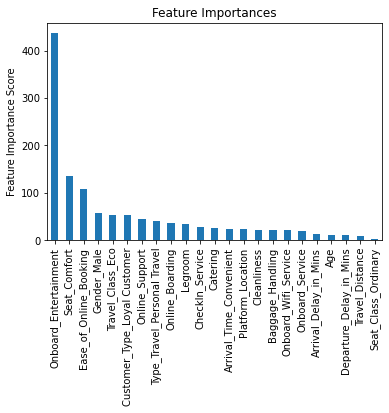

Metrics Score X_train:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     29950
           1       0.97      0.96      0.96     36115

    accuracy                           0.96     66065
   macro avg       0.96      0.96      0.96     66065
weighted avg       0.96      0.96      0.96     66065



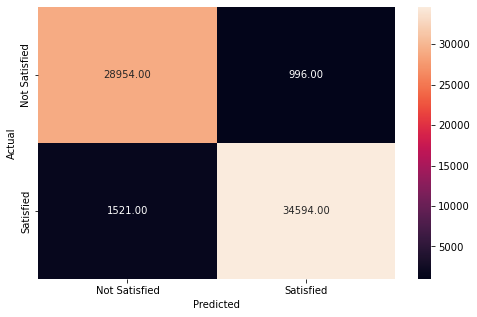

Metrics Score X_test:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     12836
           1       0.97      0.96      0.97     15478

    accuracy                           0.96     28314
   macro avg       0.96      0.96      0.96     28314
weighted avg       0.96      0.96      0.96     28314



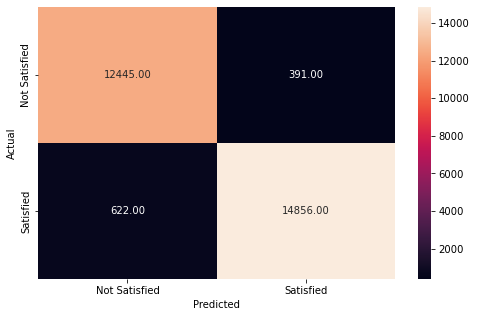

In [20]:
#Baseline model from exploratory phase, no tuning.
xgb1 = xgb.XGBClassifier(learning_rate =0.01,
                        n_estimators=1000,
                        max_depth=9,
                        min_child_weight=12,
                        gamma=0,
                        subsample=0.95,
                        colsample_bytree=0.8,
                        reg_alpha=0.1,
                        objective= 'binary:logistic',
                        nthread=4,
                        scale_pos_weight=1,
                        seed=27)


print("---------------------------------Model xgb1---------------------------------")

modelfit(xgb1, t_trainData, predictors)

y_predict_train = xgb1.predict(X_train)
y_predict_test = xgb1.predict(X_test)


print("Metrics Score X_train:")
metrics_score(y_train, y_predict_train)

print("Metrics Score X_test:")      
metrics_score(y_test, y_predict_test)

#Model submission result: 95.24465

## 6. XGB Tuning <a class="anchor" id="Tuning"></a>

In [21]:
#Tuning of max_depth and min_child_weight hyperparameters
param_test1 = {
    'max_depth':range(8,15),
    'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, 
                                                   n_estimators=140, 
                                                   max_depth=4,
                                                   min_child_weight=1, 
                                                   gamma=0, 
                                                   subsample=0.8, 
                                                   colsample_bytree=0.8,
                                                   objective='binary:logistic', 
                                                   nthread=4, 
                                                   scale_pos_weight=1, 
                                                   seed=27),
                        param_grid = param_test1,
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)

gsearch1.fit(t_trainData[predictors],t_trainData[target])
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 13, 'min_child_weight': 1}, 0.9934414526149992)

In [22]:
#Paranoid re-check of min_child_weight 
param_test2 = {'min_child_weight':range(1,15,2)}

gsearch2 = GridSearchCV(estimator=xgb.XGBClassifier(learning_rate=0.1, 
                                                n_estimators=140, 
                                                max_depth=13,
                                                min_child_weight=1, 
                                                gamma=0, 
                                                subsample=0.8, 
                                                colsample_bytree=0.8,
                                                objective= 'binary:logistic', 
                                                nthread=4, 
                                                scale_pos_weight=1,
                                                seed=27), 
                        param_grid=param_test2, 
                        scoring='roc_auc',
                        n_jobs=4, 
                        cv=5)

gsearch2.fit(t_trainData[predictors],t_trainData[target])
gsearch2.best_params_, gsearch2.best_score_

({'min_child_weight': 1}, 0.9934414526149992)

In [23]:
#Tuning of gamma hyperparameter
param_test3 = {'gamma':[i/10.0 for i in range(0,9)]}

gsearch3 = GridSearchCV(estimator=xgb.XGBClassifier(learning_rate=0.1, 
                                                n_estimators=140, 
                                                max_depth=13,
                                                min_child_weight=1, 
                                                gamma=0, 
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                objective= 'binary:logistic', 
                                                nthread=4, 
                                                scale_pos_weight=1,
                                                seed=27),
                        param_grid=param_test3, 
                        scoring='roc_auc',
                        n_jobs=4, 
                        cv=5)

gsearch3.fit(t_trainData[predictors],t_trainData[target])
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.6}, 0.9934905133533191)

In [24]:
#Tuning of subsample and colsample_bytree hyperparameters
param_test4 = {
    'subsample':[i/10.0 for i in range(5,11)],
    'colsample_bytree':[i/10.0 for i in range(5,11)]
}

gsearch4 = GridSearchCV(estimator=xgb.XGBClassifier(learning_rate=0.1, 
                                                n_estimators=180, 
                                                max_depth=13,
                                                min_child_weight=1, 
                                                gamma=0.6, 
                                                subsample=0.8, 
                                                colsample_bytree=0.8,
                                                objective= 'binary:logistic', 
                                                nthread=4, 
                                                scale_pos_weight=1,
                                                seed=27),
                        param_grid=param_test4, 
                        scoring='roc_auc',
                        n_jobs=4, 
                        cv=5)

gsearch4.fit(t_trainData[predictors],t_trainData[target])
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.7, 'subsample': 1.0}, 0.9937040999751925)

In [25]:
#Fine tuning of subsample and colsample_bytree hyperparameters
param_test5 = {
    'colsample_bytree':[i/100.0 for i in range(65,80,5)],
    'subsample':[i/100.0 for i in range(80,120,5)]
}

gsearch5 = GridSearchCV(estimator=xgb.XGBClassifier(learning_rate=0.1, 
                                                n_estimators=180, 
                                                max_depth=13,
                                                min_child_weight=1, 
                                                gamma=0.6, 
                                                subsample=0.8, 
                                                colsample_bytree=0.8,
                                                objective= 'binary:logistic', 
                                                nthread=4, 
                                                scale_pos_weight=1,
                                                seed=27),
                        param_grid=param_test5, 
                        scoring='roc_auc',
                        n_jobs=4, 
                        cv=5)

gsearch5.fit(t_trainData[predictors],t_trainData[target])
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.7, 'subsample': 1.0}, 0.9937040999751925)

In [26]:
#Tuning of reg_alpha hyperparameter
param_test6 = {'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100]}

gsearch6 = GridSearchCV(estimator=xgb.XGBClassifier(learning_rate=0.1, 
                                                n_estimators=180, 
                                                max_depth=13, 
                                                min_child_weight=1, 
                                                gamma=0.6, 
                                                subsample=1, 
                                                colsample_bytree=0.7,
                                                objective= 'binary:logistic', 
                                                nthread=4, 
                                                scale_pos_weight=1,
                                                seed=27),
                        param_grid=param_test6, 
                        scoring='roc_auc',
                        n_jobs=4, 
                        cv=5)

gsearch6.fit(t_trainData[predictors],t_trainData[target])
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 0}, 0.9937040999751925)

---------------------------------Model xgbt---------------------------------

Model Report
Accuracy : 0.9996
AUC Score (Train): 0.999999


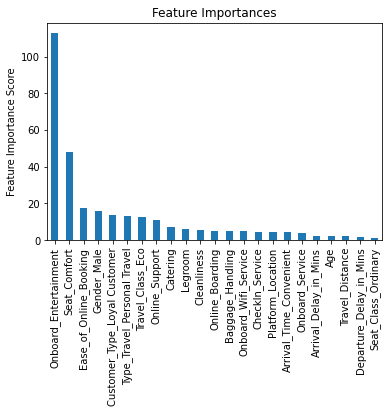

Metrics Score X_train:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29950
           1       1.00      1.00      1.00     36115

    accuracy                           1.00     66065
   macro avg       1.00      1.00      1.00     66065
weighted avg       1.00      1.00      1.00     66065



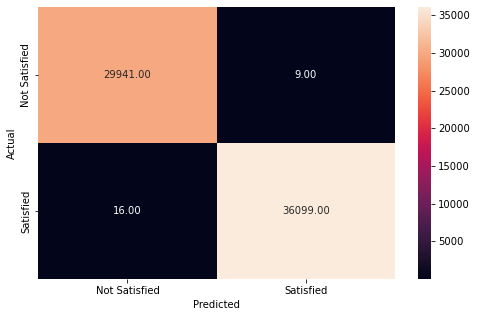

Metrics Score X_test:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12836
           1       1.00      1.00      1.00     15478

    accuracy                           1.00     28314
   macro avg       1.00      1.00      1.00     28314
weighted avg       1.00      1.00      1.00     28314



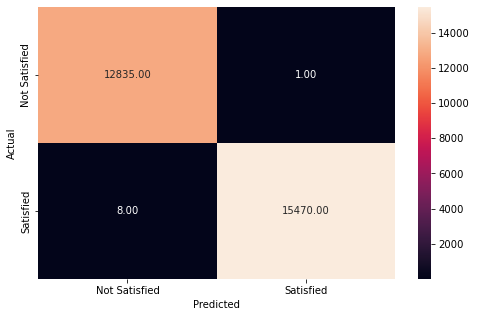

In [27]:
#Creation, fitting and testing of the tuned model
xgbt = xgb.XGBClassifier(learning_rate =0.1,
                     n_estimators=5000,
                     max_depth=13,
                     min_child_weight=1,
                     gamma=0.6,
                     subsample=1,
                     colsample_bytree=0.7,
                     reg_alpha=0,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)

print("---------------------------------Model xgbt---------------------------------")
modelfit(xgbt, t_trainData, predictors)

y_predict_train = xgbt.predict(X_train)
y_predict_test = xgbt.predict(X_test)


print("Metrics Score X_train:")
metrics_score(y_train, y_predict_train)

print("Metrics Score X_test:")      
metrics_score(y_test, y_predict_test)

## 7. CSV Submission <a class="anchor" id="Submission"></a>

In [ ]:
#Predict submission and generate CSV 
#df_test1 = t_testData.copy()
#pred = xgbt.predict(X_t)
#df_test1['Overall_Experience'] = pred
#sample = df_test1[['ID', 'Overall_Experience']]
#sample.to_csv('XGBT_202211122317.csv',index=False)

#Submission result: 95.64912 obtaining a 2nd place
#1st place score:   95.74743


## 8. Further work and undeveloped ideas <a class="anchor" id="Future"></a>


__1 -__ It might be interesting to review the miss-classified cases and look for any common patterns or characteristics that can be used to classify them properly.


In [28]:
df_predictedTrain = X_train.copy()
df_predictedTrain["Overall_Experience"] = y_train.values
df_predictedTrain["Predicted"] = y_predict_train
p0 = (df_predictedTrain["Predicted"]==1) 
a1 = (df_predictedTrain["Overall_Experience"]==1)
df_trainErrors = df_predictedTrain[p0!=a1]

df_predictedTest = X_test.copy()
df_predictedTest["Overall_Experience"] = y_test.values
df_predictedTest["Predicted"] = y_predict_test
p0 = (df_predictedTest["Predicted"]==1) 
a1 = (df_predictedTest["Overall_Experience"]==1)
df_testErrors = df_predictedTest[p0!=a1]

allErrors = pd.concat([df_trainErrors, df_testErrors], axis=0)

In [29]:
display(allErrors.shape)

(34, 25)

In [30]:
display(allErrors)

,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Comfort,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,Gender_Male,Customer_Type_Loyal Customer,Type_Travel_Personal Travel,Travel_Class_Eco,Seat_Class_Ordinary,Overall_Experience,Predicted
68376,25.0,2420,53.0,64.0,3,3,3,2,2,3,2,2,3,2,3,4,4,2,1,0,0,1,0,1,0
71529,39.0,1800,0.0,0.0,2,3,2,3,2,2,2,2,4,4,3,2,3,2,0,0,0,1,1,1,0
29970,28.0,1507,0.0,0.0,4,1,1,4,4,4,4,4,3,1,3,4,2,4,0,1,0,1,1,0,1
55848,22.0,2051,0.0,0.0,3,3,3,2,3,3,3,3,5,4,4,3,4,3,1,0,0,1,1,1,0
43277,27.0,1537,0.0,0.0,4,2,3,2,4,4,4,4,3,4,4,2,4,4,0,1,1,1,1,0,1
91227,20.0,2222,0.0,0.0,3,3,3,2,5,3,5,5,2,4,4,2,4,5,1,0,0,1,1,1,0
43089,55.0,1603,0.0,0.0,3,3,3,3,3,3,3,3,2,2,3,3,3,3,1,1,0,1,1,1,0
30265,23.0,3136,0.0,10.0,2,2,2,1,2,2,2,2,3,3,3,3,4,2,0,1,0,0,0,1,0
29827,48.0,1929,0.0,0.0,3,5,5,5,3,3,3,3,2,5,4,3,3,3,1,1,0,1,0,1,0
19288,52.0,1578,0.0,1.0,3,3,1,4,2,3,2,2,3,4,4,2,4,2,1,1,0,1,1,1,0


## 8. Final notes <a class="anchor" id="Notes"></a>

__1 -__ By preparing this document, I found out the tuned model I used for the 95.64912 submission had an error.

When tunning the reg_alpha parameter, I only tested for values above 0 and didn't notice the score decreased with the best reg_alpha value found (0.13). I should have noticed that the default value of 0 generated better results.

On this notebook this error was corrected, but there's no way to measure the impact on the submission score using the corrected model.

The original model had a total(X_train + X_test) of 210 misclassifications in the metrics_score evaluation, while the corrected model had 34.